# Predict the Critical Temperature of a Superconductor with Random Forest
This notebook will reproduce and improve the Random Forest results of `predict_tc` in the Python language.

The paper makes these points about random forest implementation.

> We also tried random forests but they were too slow to tune given the data size and the number of features.

> Scalability and speed are important advantages of using XGBoost over random forests

In [ ]:
# Install `pyCHNOSZ` if not installed already.
!pip install pyCHNOSZ

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pyCHNOSZ
from sklearn.ensemble import RandomForestRegressor
from load_data import load_and_split
from pyplot_data import plot_observed_vs_predicted

>**Out-Of_sample RMSE Estimation Procedure**
>1. At random divide the data into 2/3 train and 1/3 test data.

In [15]:
training_X, training_y, testing_X, testing_y = load_and_split()

Data Shape: (21263, 82)
Training Features Shape: (14033, 81)
Training Labels Shape: (14033, 1)
Testing Features Shape: (7230, 81)
Testing Labels Shape: (7230, 1)


>2. Fit the model using the train data.

The `main_script_production_9.R` (line 1563) uses the package `ranger` to implement random forests with number of trees set to `2500`.
>```R
>tmp_rf_model = ranger(critical_temp ~ ., data = train, num.trees = 2500)
>```

with the `mtry` argument set to 9 (line 1555)

>`Try a timing with but change num.trees to 2500, and default of mtry = 9`

> [`mtry`](https://www.rdocumentation.org/packages/ranger/versions/0.14.1/topics/ranger) - Number of variables to possibly split at in each node. Default is the (rounded down) square root of the number variables. Alternatively, a single argument function returning an integer, given the number of independent variables.

For `sklearn.ensemble.RandomForestRegressor` we will use the `min_samples_split` parameter.

>[`min_samples_split`: *int or float, default = 2*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) - The minimum number of samples required to split an internal node.

In [19]:
forest_mtry_9 = RandomForestRegressor(n_estimators=2500, min_samples_split=9)
forest_mtry_9.fit(training_X, training_y)

/tmp/ipykernel_16179/3351446048.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_mtry_9.fit(training_X, training_y)


RandomForestRegressor(min_samples_split=9, n_estimators=2500)

The paper also creates another model with `mtry` set to `50`.

In [ ]:
forest_mtry_50 = RandomForestRegressor(n_estimators=2500, min_samples_split=50)
forest_mtry_50.fit(training_X, training_y)

>3. Predict $T_c$ of the test data.

Score: 0.9230398705444511


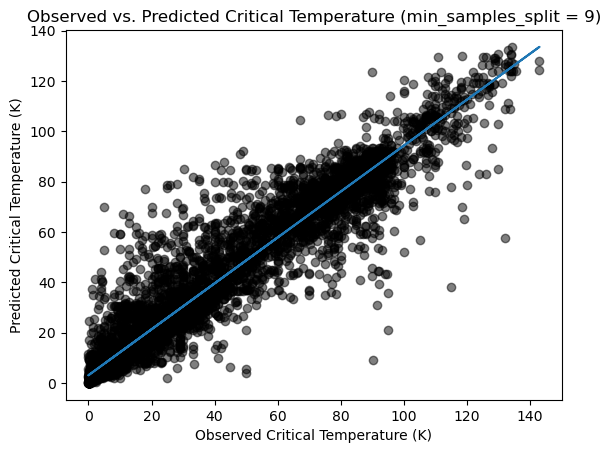

In [32]:
# Creates random forest predictions with testing features.
prediction_forest_mtry_9 = forest_mtry_9.predict(testing_X)

print(f"Score: {forest_mtry_9.score(testing_X, testing_y)}")

plot_observed_vs_predicted(
    testing_y,
    prediction_forest_mtry_9,
    title="Observed vs. Predicted Critical Temperature (min_samples_split = 9)"
)

> 4. Obtain an estimate of the out-of-sample mean-squared-error (mse) by using the predictions from the last step and the observed $T_c$ values in the test data:
>$$out\;of\;sample\;mse=Average\;of\;(observed-predicted)^2$$